<a href="https://colab.research.google.com/github/Neuralwood-Net/face-recognizer-9000/blob/main/notebooks/plot_confusion_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learn SqueezeNet to four-class face recognition


### Make sure the hardware is in order

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Nov 13 18:03:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Imports

In [3]:
import time
import os
import copy
import sys

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import torchvision
from torchvision import datasets, models, transforms

from google.cloud import storage

# Placeholder to make it run until the real WoodNet is defined
class WoodNet:
    pass

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Fetch and extract the data from the storage bucket

In [5]:
# Define paths separate from the heavy operations below
BASE_PATH = "/content"

BLOB_NAME = "faces/balanced_sampled_224px_color_156240_images_70_15_15_split.zip"
zipfilename = os.path.join(BASE_PATH, BLOB_NAME)
extract_to_dir = os.path.join(BASE_PATH, *BLOB_NAME.split(os.path.sep)[:-1])

In [6]:
# Fetch the data
from google.cloud import storage

# Make the required directories
os.makedirs(os.path.join(BASE_PATH, "faces"), exist_ok=True)
os.makedirs(os.path.join(BASE_PATH, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(BASE_PATH, "logs"), exist_ok=True)

with open(zipfilename, "wb") as f:
    storage.Client.create_anonymous_client().download_blob_to_file(f"gs://tdt4173-datasets/{BLOB_NAME}", f)

In [7]:
# Extract the data
import zipfile

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

### Load the data into wrapper classes and apply normalization

In [8]:
BATCH_SIZE = 16

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

data_dir = os.path.join(extract_to_dir, "sampled_dataset_balanced_244")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms)
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print(class_names)
print(image_datasets['val'].classes)
print(dataset_sizes)

['Kjartan', 'Lars', 'Morgan', 'Other']
['Kjartan', 'Lars', 'Morgan', 'Other']
{'train': 109368, 'val': 23437, 'test': 23436}


### Create a helper function to aid in image plotting and show a random sample of the input data

torch.Size([16, 3, 224, 224])


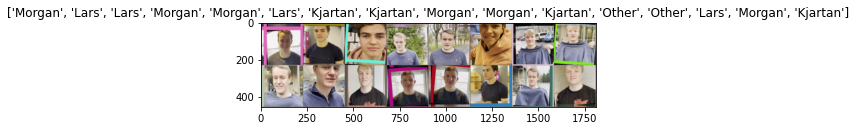

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Create a function for training and validation
The following function trains the supplied model with the loss criterion and optimizer supplied, for the specified number of epochs. During training it logs the loss and accuracy for both training and validation. Whenever a better model is found on the validation set, the function saves the model parameters to a file for use for inference later.

In [26]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    modelname = f"{type(model).__name__}-{since}"
    print(f"Training model: `{type(model).__name__}`")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    num_img = {
        "train": 0,
        "val": 0,
    }
    
    datapoints_per_epoch = 100

    imgs_per_datapoint = {
        "train": int(float(dataset_sizes["train"] / datapoints_per_epoch)),
        "val": int(float(dataset_sizes["val"] / datapoints_per_epoch)),
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)
        
        with open(os.path.join(BASE_PATH, f"logs/{modelname}.csv"), "a") as f:

            # For each epoch we want to both train and evaluate in that order
            for phase in ["train", "val"]:
                if phase == "train":
                    # Makes the network ready for training, i.e. the parameters can be tuned
                    # and possible Dropouts are activated
                    model.train()
                else:
                    # Makes the network ready for inference, i.e. it is not tunable and will
                    # turn off regularization that might interfere with training
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                plot_loss = 0
                plot_corrects = 0

                # Iterate over training or validation data
                for inputs, labels in tqdm(dataloaders[phase], desc=f"Epoch: {epoch} ({phase})", file=sys.stdout):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Reset the gradients before calculating new ones
                    optimizer.zero_grad()

                    
                    # Ask PyTorch to generate computation graph only if in training mode
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Only perform update steps if we're training
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()


                    # Save values for statistics and logging
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    plot_loss += loss.item() * inputs.size(0)
                    plot_corrects += torch.sum(preds == labels.data)
                    
                    num_img[phase] += BATCH_SIZE
                    
                    if num_img[phase] % imgs_per_datapoint[phase] == 0:
                        f.write(f"{time.time()},{epoch},{phase},\
                        {num_img[phase]},{plot_loss / float(imgs_per_datapoint[phase])},\
                        {plot_corrects / float(imgs_per_datapoint[phase])}\n")
                        
                        plot_loss = 0
                        plot_corrects = 0

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

                # deep copy the model
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(
                        {
                            "loss": epoch_loss,
                            "acc": epoch_acc,
                            "epoch": epoch,
                            "parameters": best_model_wts,
                        },
                        os.path.join(BASE_PATH, f"checkpoints/{modelname}.data"),
                    )
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Prepare the home-made CNN – WoodNet
Below is two networks. The first is made by the authors, and is made to be trained from scratch on the training data. The other is fully trained on ImageNet (1000 classes) and fine-tuned on the training data.

In [41]:
class WoodNet(nn.Module):
    size_after_conv = 7 * 7 * 64
    def __init__(self):
        super(WoodNet, self).__init__()
        self.features = nn.Sequential(   
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.classify = nn.Sequential(
            nn.Linear(self.size_after_conv, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, len(class_names)),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.size_after_conv)
        x = self.classify(x)

        return x

woodnet = WoodNet().to(device)
print(woodnet)

WoodNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU()
  )
  (classify): Sequential(
    (0): Linear(in_features=3136, out_features=2048, bia

### Make a bad net called BadNet 
Below is a quickly made model which will be used mostly to display WoodNet and SqueezeNets superioritey. 




In [24]:
class BadNet(nn.Module):
    size_after_conv = 7 * 7 * 64
    def __init__(self):
        super(BadNet, self).__init__()
        
        self.classify = nn.Sequential(
            nn.Linear(224*224*3, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, len(class_names)),
        )

    def forward(self, x):
        x = x.view(-1, 224*224*3)
        x = self.classify(x)

        return x

badnet = BadNet().to(device)
badnet

BadNet(
  (classify): Sequential(
    (0): Linear(in_features=150528, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=4, bias=True)
  )
)

### Prepare the pretrained CNN – SqueezeNet
Below is the code for loading in the pretrained SqueezeNet. After it is loaded, the last classification layer is replaced with a one with the correct amount of output classes.

In [27]:
# network = squeezenet
network = badnet
train_full_network = False

if train_full_network or isinstance(network, (WoodNet, BadNet)):
    print("Training full network")
    parameters = network.parameters()
else:
    print("Training only last layer of SqueezeNet")
    parameters = network.classifier[1].parameters()

optimizer = torch.optim.SGD(parameters, lr=0.001, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

train_model(network, loss_function, optimizer, num_epochs=25)

Training full network
Training model: `BadNet`
Epoch 0/24
----------
Epoch: 0 (train): 100%|██████████| 6836/6836 [04:48<00:00, 23.72it/s]
train Loss: 1.1622 Acc: 0.5586
Epoch: 0 (val): 100%|██████████| 1465/1465 [00:59<00:00, 24.47it/s]
val Loss: 1.0314 Acc: 0.6679

Epoch 1/24
----------
Epoch: 1 (train):  35%|███▍      | 2376/6836 [01:40<03:16, 22.73it/s]

KeyboardInterrupt: ignored

### Upload model weights and training logs to storage

In [ ]:
# Upload checkpoints to storage
client = storage.Client.from_service_account_json("/content/drive/My Drive/## Project/TDT4173 Deep Learning Project-91d3b469375c.json")
bucket = client.get_bucket("tdt4173-datasets")

blob = bucket.blob("checkpoints/SqueezeNet-1605290736.1277423.data")
filename = "/content/checkpoints/SqueezeNet-1605290736.1277423.data"
blob.upload_from_filename(filename)

blob = bucket.blob("checkpoints/WoodNet-1605294933.5362356.data")
filename = "/content/checkpoints/WoodNet-1605294933.5362356.data"
blob.upload_from_filename(filename)

In [ ]:
# Upload logs to storage
blob = bucket.blob("logs/SqueezeNet-1605290215.097698.csv")
filename = "/content/logs/SqueezeNet-1605290215.097698.csv"
blob.upload_from_filename(filename)

blob = bucket.blob("logs/SqueezeNet-1605290736.1277423.csv")
filename = "/content/logs/SqueezeNet-1605290736.1277423.csv"
blob.upload_from_filename(filename)

blob = bucket.blob("logs/WoodNet-1605294933.5362356.csv")
filename = "/content/logs/WoodNet-1605294933.5362356.csv"
blob.upload_from_filename(filename)

### Visualize the model performance for some images

In [12]:
with open("/content/squeeze.data", "wb") as f:
    storage.Client.create_anonymous_client().download_blob_to_file("gs://tdt4173-datasets/checkpoints/SqueezeNet-1605290736.1277423.data", f)

In [40]:
with open("/content/woodnet.data", "wb") as f:
    storage.Client.create_anonymous_client().download_blob_to_file("gs://tdt4173-datasets/checkpoints/WoodNet-1605294933.5362356.data", f)

In [ ]:
squeezenet = models.squeezenet1_1()
num_ftr = squeezenet.classifier[1].in_channels
squeezenet.classifier[1] = nn.Conv2d(num_ftr, 4, 1, 1)

data = torch.load("/content/squeeze.data")

squeezenet.load_state_dict(data["parameters"])
squeezenet = squeezenet.to(device)
squeezenet.eval()

In [42]:


data = torch.load("/content/woodnet.data")

woodnet.load_state_dict(data["parameters"])
woodnet = woodnet.to(device)
woodnet.eval()

WoodNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU()
  )
  (classify): Sequential(
    (0): Linear(in_features=3136, out_features=2048, bia

Below is a function which returns all true lables and a models predicted values

In [14]:
@torch.no_grad()
def get_all_preds_labels(model, loader):
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)

    for inputs, labels in tqdm(loader):
        labels = labels.to(device)
        inputs = inputs.to(device)

        preds = model(inputs)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_labels = torch.cat(
            (all_labels, labels)
            ,dim=0
        )
    return all_preds, all_labels


In [15]:
test_preds, test_labels = get_all_preds_labels(squeezenet,dataloaders["test"])

100%|██████████| 1465/1465 [00:55<00:00, 26.24it/s]


In [ ]:
 #[actual,predicted]
 stacked = torch.stack(
    (
        test_labels
        ,test_preds.argmax(dim=1)
    )
    ,dim=1
)
stacked.shape

torch.Size([23436, 2])

This is a convolutional matrix in tensor form, not used for the visualisation, but we provide it as it can be useful in some cases

In [16]:
def cm_tensor(stacked):
  cm_tensor = torch.zeros(4,4, dtype=torch.int64)
  for pair in stacked:
    al,pl = pair.tolist()
    cm_tensor[int(al),int(pl)] = cm_tensor[int(al),int(pl)] + 1
  

In [18]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


The plotting is done on the cpu. As such we return our calculated test predictions and acutal labels to be calculated on the cpu. 

In [20]:

test_labels = test_labels.cpu()
test_preds = test_preds.cpu()

cm = confusion_matrix(test_labels, test_preds.argmax(dim=1))


The below plotter is based on the code from DeepLizard: https://deeplizard.com/learn/video/0LhiS6yu2qQ?fbclid=IwAR1Zb3LSBe4nhuxa6OhwpW4-rXwg7LhMIeG0C0iCWMrYLH2Bkhfh-z5IaL0 

In [34]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, filename, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print(filename)
    plt.savefig(filename)
# plot_confusion_matrix(cm,class_names)


100%|██████████| 1465/1465 [00:59<00:00, 24.83it/s]


/content/woodnet_cm.png


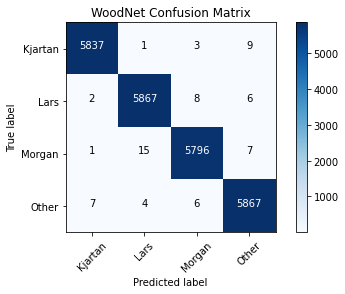

In [43]:
#test_preds, test_labels = get_all_preds_labels(model,dataloader_and_type)


def cnn_constructor(preds,labels,filename,title): 
    stacked = torch.stack(
      (
          labels
          ,preds.argmax(dim=1)
      )
      ,dim=1
    )
    labels = labels.cpu()
    preds = preds.cpu()
    cm = confusion_matrix(labels, preds.argmax(dim=1))
    plot_confusion_matrix(cm,class_names,filename,title=title)
#SqueezeNet
#test_preds_s,test_labels_s=get_all_preds_labels(squeezenet,dataloaders["test"])
#cnn_constructor(test_preds_s,test_labels_s,"/content/squeezenet_cm.png",title="SqueezeNet Confusion Matrix");
#WoodNet
test_preds_w,test_labels_w = get_all_preds_labels(woodnet,dataloaders["test"])
cnn_constructor(test_preds_w,test_labels_w,"/content/woodnet_cm.png",title="WoodNet Confusion Matrix");

# test_preds,test_labels = get_all_preds_labels(badnet,dataloaders["test"])
#cnn_constructor(test_preds,test_labels,"/content/badnet_cm.png",title="BadNet Confusion Matrix");
